# University network

In [81]:
import json
import ast
import networkx as nx
from matplotlib import pyplot as plt
import itertools
from tqdm import tqdm
import pandas as pd
from collections import Counter, defaultdict
pd.set_option('display.max_rows', 200)
import numpy as np
import community
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

import os
import time

In [82]:
pd.options.display.max_rows

200

## Read data from csv file (this csv file was created in the preprocessing notebook)

In [83]:
df_uni = pd.read_csv('2019_uni_weighted_edges.csv')

In [84]:
all_orgs = set(df_uni.org1).union(set(df_uni.org2))

In [85]:
dict_aliases = {}
renamed = set()

def rename(org_str,name):
    aliases = []
    for org in list(all_orgs):
        if org == org:
            if(org.find(org_str)>-1):
                aliases.append(org)
    count = 0
    for alias in aliases:
        dict_aliases[alias] = name
        count += 1
    print(f'Number of aliases for {name} : {count}')
    renamed.add(name)

In [86]:
rename('Harvard','Harvard')
rename('Beihang University','Beihang University')
rename('Carnegie','Carnegie - Mellon')
rename('Institute of Electrical and Electronics Engineers','Institute of Electrical and Electronics Engineers')
rename('Johns Hopkins','Johns Hopkins University')
rename('MIT','MIT')
rename('massachusetts institute of technology','MIT')
rename('National University of Singapore','National University of Singapore')
rename('Northeastern','Northeastern University')
rename('Peking','Peking University')
rename('Princeton','Princeton University')
rename('Southern California','University of Southern California')
rename('Stanford','Stanford University')
rename('Tsinghua','Tsinghua University')
rename('UC Berkeley','UC Berkeley')
rename('Xidian University','Xidian University')
rename('Cambridge','University of Cambridge')
rename('Oxford','University of Oxford')
rename('Columbia University','Columbia University')
rename('Yale','Yale')
rename('Cornell','Cornell')
rename('University of Tokyo','University of Tokyo')
rename('Duke','Duke')
rename('University of Chicago','University of Chicago')
rename('University of California, Berkeley','UC Berkeley')
rename('Microsoft','Microsoft')
rename('GOOGLE','Google')
rename('Technical University of Munich','Technical University of Munich')
rename('Zhejiang','Zhejiang Univ')
rename('Imperial College','Imperial College London')
rename('IBM','IBM')
rename('UCLA','UCLA')
rename('City University of Hong Kong','City University of Hong Kong')
rename('University Of California, Davis','University Of California, Davis')
rename('University of British Columbia','University of British Columbia')
rename('University of Utah','University of Utah')
rename('Royal Institute of Tech','Royal Institute of Tech')
rename('University of Pennsylvania','University of Pennsylvania')
rename('Hangzhou Dianzi','Hangzhou Dianzi')
rename('nVIDIA','nVIDIA')
rename('of Oulu','University of Oulu Finland')
rename('Kyushu University','Kyushu University')
rename('TU WIEN','TU WIEN')
rename('Shanghai Jiao Tong university','Shanghai Jiao Tong university')
rename('University of Virginia','University of Virginia')
rename('ETH Zürich','ETH Zürich')
rename('Amazon','Amazon')


Number of aliases for Harvard : 267
Number of aliases for Beihang University : 243
Number of aliases for Carnegie - Mellon : 216
Number of aliases for Institute of Electrical and Electronics Engineers : 1
Number of aliases for Johns Hopkins University : 158
Number of aliases for MIT : 249
Number of aliases for MIT : 1
Number of aliases for National University of Singapore : 156
Number of aliases for Northeastern University : 198
Number of aliases for Peking University : 296
Number of aliases for Princeton University : 90
Number of aliases for University of Southern California : 133
Number of aliases for Stanford University : 206
Number of aliases for Tsinghua University : 404
Number of aliases for UC Berkeley : 26
Number of aliases for Xidian University : 240
Number of aliases for University of Cambridge : 605
Number of aliases for University of Oxford : 276
Number of aliases for Columbia University : 145
Number of aliases for Yale : 90
Number of aliases for Cornell : 135
Number of ali

In [87]:
for org in list(all_orgs):
    if(org not in dict_aliases.keys()):
        dict_aliases[org] = org

In [88]:
df_uni['_org1'] = df_uni.org1.apply(lambda x: dict_aliases[x])
df_uni['_org2'] = df_uni.org2.apply(lambda x: dict_aliases[x])

In [89]:
df_uni = df_uni[['_org1','_org2','weight']]
df_uni.columns = ['org1','org2','weight']

In [90]:
df_uni = df_uni.groupby(['org1','org2'])[['weight']].sum().reset_index()

In [91]:
df_uni.sort_values(by = 'weight', ascending = False)

,org1,org2,weight
182103,Tsinghua University,Tsinghua University,492
161488,Peking University,Peking University,375
192353,Zhejiang Univ,Zhejiang Univ,289
191707,Xidian University,Xidian University,281
23852,Beihang University,Beihang University,224
...,...,...,...
73059,"Department of Computer and Technology, College...","Dundee Business School, Abertay University, Le...",1
73060,Department of Computer and information Technol...,"IDP-Educational Technology, IIT Bombay",1
73061,Department of Computer and information Technol...,University of Cincinnati,1
73062,Department of Computer and information Technol...,Xi’an Jiaotong University,1


In [92]:
df_uni['valid_colab'] = df_uni.org1 != df_uni.org2

In [93]:
df_uni = df_uni[df_uni.valid_colab == True]

In [94]:
df_uni.sort_values(by = 'weight', ascending = False)

,org1,org2,weight,valid_colab
186666,University of Cambridge,MIT,211,True
150934,Microsoft,Tsinghua University,177,True
150740,Microsoft,Peking University,106,True
33174,CMU;,Carnegie - Mellon,83,True
150512,Microsoft,Carnegie - Mellon,63,True
...,...,...,...,...
73047,Department of Computer and Software Nanjing Un...,"New Jersey Institute of Technology , Newark , USA",1,True
73048,Department of Computer and Software Nanjing Un...,State Key Laboratory of Mathematical Engineeri...,1,True
73049,"Department of Computer and Software, Hanyang U...",HanYang Univ.,1,True
73050,"Department of Computer and Software, Hanyang U...",Naver Corporation,1,True


## Filter organization for more than one colab

In [95]:
G = nx.from_pandas_edgelist(df_uni[['org1','org2','weight']],'org1','org2', edge_attr='weight')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 91639
Number of edges: 190802
Average degree:   4.1642


In [96]:
def plot_degree_dist(G):
    degree_hist = nx.degree_histogram(G) 
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.set_title('Degree Distribution')
    
    plt.show()

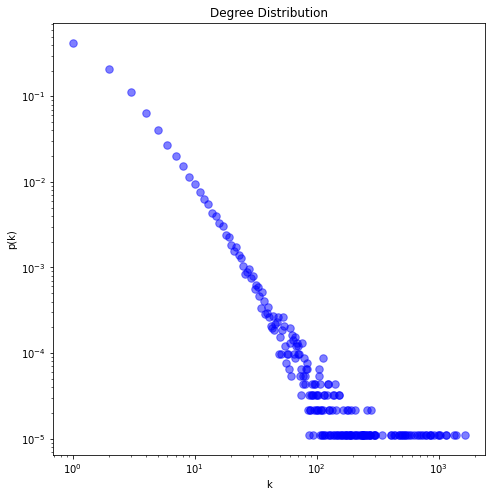

Name: 
Type: Graph
Number of nodes: 91639
Number of edges: 190802
Average degree:   4.1642


In [97]:
plot_degree_dist(G)
print (nx.info(G))

In [98]:
def plot_strength_dist(G):
    strength_lst = list(dict(G.degree(weight='weight')).values())
    max_val = max(strength_lst)
    strength_hist = np.histogram(strength_lst, np.arange(max_val+2))[0]
    strength_hist = strength_hist.astype('float64')
    strength_prob = strength_hist/len(strength_lst)
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(strength_prob.shape[0]), strength_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('s')
    axes.set_ylabel('p(s)')
    axes.set_title('Strength Distribution')
    
    plt.show()

In [99]:
df_uni[(df_uni.org1 == 'Ariel University') ]

,org1,org2,weight,valid_colab
19177,Ariel University,"Capital One, Arlington, VA, USA#TAB#",1,True
19178,Ariel University,"Communication Systems Engineering, Ben-Gurion ...",1,True
19179,Ariel University,"Cyber Innovation Center, Department of Compute...",1,True
19180,Ariel University,"Department of Computer Science, Ariel Universi...",3,True
19181,Ariel University,Department of Disaster Management and Injury P...,1,True
19182,Ariel University,Department of Electrical and Systems Engineeri...,2,True
19183,Ariel University,Department of Industrial Engineering & Managem...,1,True
19184,Ariel University,"Department of Information Systems, Sam M. Walt...",2,True
19185,Ariel University,"Dept. of Information & Knowledge Management, F...",1,True
19186,Ariel University,"Faculty of Management, University of Haifa, Ha...",1,True


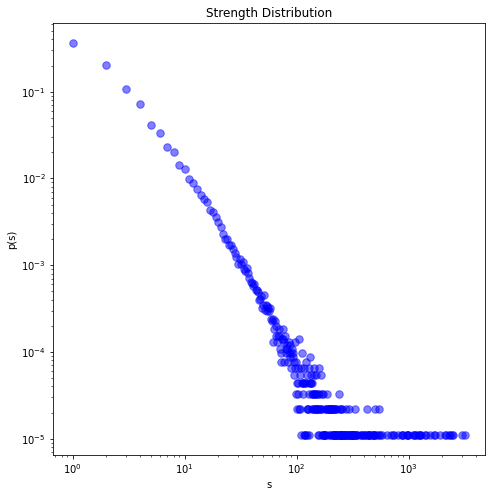

In [100]:
plot_strength_dist(G)

In [101]:
def plot_weight_dist(G): 
    weight_lst = list(nx.get_edge_attributes(G,'weight').values())
    max_val = max(weight_lst)
    weight_hist = np.histogram(weight_lst, np.arange(max_val+2))[0]
    weight_hist = weight_hist.astype('float64')
    weight_prob = weight_hist/len(weight_lst)
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(weight_prob.shape[0]), weight_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('w')
    axes.set_ylabel('p(w)')
    axes.set_title('Weight Distribution')
    
    plt.show()

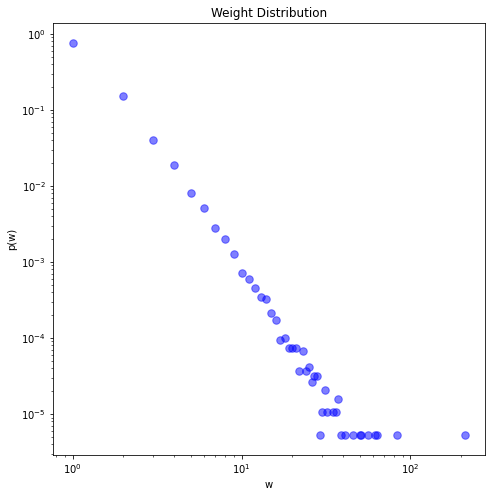

In [102]:
plot_weight_dist(G)

In [103]:
def plot_k_vs_s(G):
    
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(list(dict(G.degree()).values()), list(dict(G.degree(weight='weight')).values()), 
                'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('s')
    axes.set_title('degree vs. strength')

    plt.plot([0,2000],[0,2000], color = 'r')
    
    plt.show()

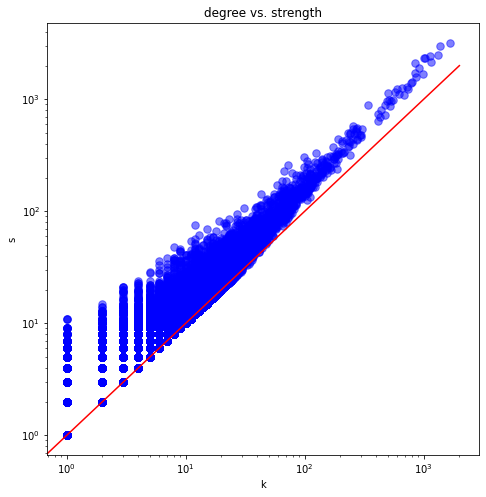

In [104]:
plot_k_vs_s(G)

## Path length

In [105]:
if nx.is_connected(G):
    print (nx.average_shortest_path_length(G))
else:
    print ('Graph not connected: infinite path length')

Graph not connected: infinite path length


## KNN(k)

In [106]:
def fit_func(x,a,mu):
    return (a*x)**mu

In [107]:
from scipy.optimize import curve_fit 

In [108]:
def plot_knn(G, fit=True): 
    knn_dict = nx.k_nearest_neighbors(G) # k_nearest_neighbors return dict with knn for each k
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('knn(k)')
    axes.set_title('Average next neighbor degree')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst),maxfev=10000)
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()

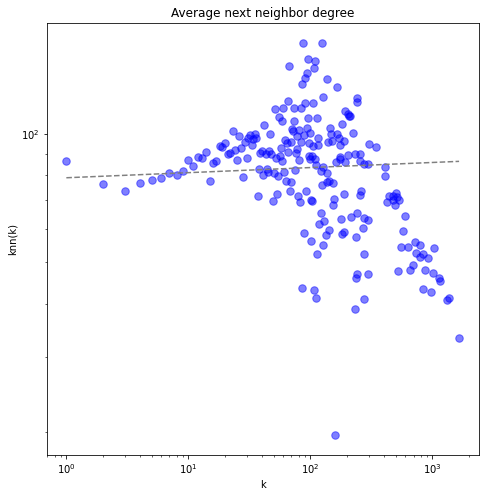

In [109]:
plot_knn(G)

## Clustering coefficient


In [110]:
print (nx.average_clustering(G))

0.1909772752214129


In [111]:
def plot_clustering_coefficient(G):
    clustering_dict = {}
    for node in G.nodes():
        k = G.degree(node)
        if not k in clustering_dict:
            clustering_dict[k] = [nx.clustering(G,node)]
        else:
            clustering_dict[k].append(nx.clustering(G,node))
    k_lst = sorted(clustering_dict.keys())
    clustering_lst = []
    for k in k_lst:
        clustering_lst.append(np.array(clustering_dict[k]).mean())
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,clustering_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title('Average clustering coefficient')
    
    plt.show()

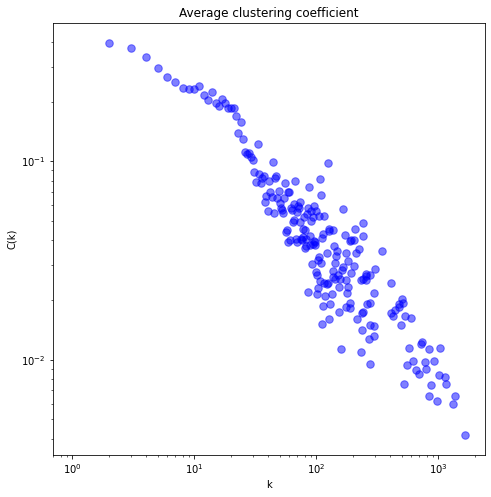

In [112]:
plot_clustering_coefficient(G)

In [113]:
print ('Size of largest component: %s' % len(max(nx.connected_components(G), key=len)))
print ('Degree Assortativity Coefficient (r): %s' % nx.degree_assortativity_coefficient(G))

Size of largest component: 75174
Degree Assortativity Coefficient (r): -0.03291226485354246


## Centrality

In [114]:
deg_cen = nx.algorithms.centrality.degree_centrality(G)
sorted_deg_cen = {k: v for k, v in sorted(deg_cen.items(), key=lambda item: item[1],reverse=True)}


## Modulairty

In [115]:
k = 100
top_k_colaborators = list(sorted_deg_cen.keys())[:k]

In [116]:
top_k_df = df_uni[(df_uni.org1.isin(top_k_colaborators)) & (df_uni.org2.isin(top_k_colaborators))].copy().reset_index()

In [117]:
top_k_df = top_k_df[['org1','org2','weight']]

In [118]:
top_k_df['_org1'] = ''
top_k_df['_org2'] = ''
for idx,row in top_k_df.iterrows():
    org1_str = row.org1
    srt1_repl = org1_str.replace('#TAB#','').replace('#R#','').replace('#N#','').replace('                 ','')
    top_k_df.iloc[idx,3] = srt1_repl
    org2_str = row.org2
    srt2_repl = org2_str.replace('#TAB#','').replace('#R#','').replace('#N#','').replace('                 ','')
    top_k_df.iloc[idx,4] = srt2_repl

In [119]:
G_top = nx.from_pandas_edgelist(top_k_df[['_org1','_org2','weight']],'_org1','_org2', edge_attr='weight')
print(nx.info(G_top))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 1580
Average degree:  31.6000


In [120]:
louvain_partition = community.best_partition(G_top, weight='weight')
modularity_louvain = community.modularity(louvain_partition, G_top, weight='weight')
print(f'The nummber of clusters using Louvain is {len(set(louvain_partition.values()))}')
print(f'Louvain modularity is {modularity_louvain}')

The nummber of clusters using Louvain is 5
Louvain modularity is 0.18728809459873916


In [121]:
greedy_modularity = greedy_modularity_communities(G_top,weight='weight')
modularity_greedy = modularity(G_top,greedy_modularity,weight='weight')
# print(f'The nummber of clusters using Louvain is {len(set(greedy_modularity.values()))} ')
# print(f'Louvain modularity is {modularity_louvain}')

In [122]:
modularity_greedy

0.005990900197418591

In [123]:
# nx.write_gml(G_top,'top_100_colaborators.gml')

## Tel aviv university analysis

In [124]:
tel_aviv_vari= ['Israel',
 'Adi Lautman Interdisciplinary Program for Outstanding Students, Tel Aviv University, Tel-Aviv, Israel',
 'Blavatnik Sch. of Comput. Sci., Tel Aviv Univ., Tel Aviv, Israel',
 'Blavatnik School of Computer Science, Tel Aviv University, , Israel',
 'Blavatnik School of Computer Science, Tel Aviv University, Tel Aviv, Israel',
 'Computer Science, Tel Aviv University, 26745 Tel Aviv, NA Israel 6997801 (e-mail: nadavbar@mail.tau.ac.il)',
 'Curiosity Lab, Department of Industrial Engineering, Tel Aviv University, Israel',
 'Department of Biochemistry and Molecular Biology, George S. Wise Faculty of Life Sciences, Tel Aviv University, Tel Aviv, Israel.',
 'Department of Disaster Management and Injury Prevention, Tel-Aviv University, Tel Aviv, Israel',
 'Department of EE-Systems, Tel Aviv University, Tel Aviv, Israel#TAB#',
 'Department of Electrical Engineering, Tel-Aviv University, Tel-Aviv, Israel#TAB#',
 'Department of Electrical Engineering-Systems, Tel Aviv University, Tel Aviv, 6997801, Israel',
 'Department of Human Molecular Genetics and Biochemistry, Sackler School of Medicine, Tel-Aviv University, Tel-Aviv, Israel',
 'Department of Industrial Engineering, Tel Aviv University, Tel Aviv, Israel',
 'Department of Neurobiology, Faculty of Life Sciences, Tel Aviv University, Tel Aviv, 6997801, Israel',
 'Department of Sociology and Anthropology, Tel-Aviv University',
 'Department of Statistics & Operations Research, Tel Aviv University, Tel Aviv, Israel#TAB#',
 'Faculty of Management, Tel Aviv University, Tel Aviv 6997801, Israel;',
 'Faculty of engineering, Tel Aviv University',
 'Laboratory for AI, Machine Learning, Business & Data Analytics, Department of Industrial Engineering, The Tel-Aviv University, Ramat-Aviv 6997801 and Israel, --- Select a Country ---',
 'Multiple Sclerosis Center, Sackler School of Medicine University, Tel-Hashomer, Tel-Aviv Israel',
 'Porter School of the Environment and Earth Sciences, Faculty of Exact Sciences, Tel-Aviv University, Israel',
 'Sagol Brain Institute, Wohl Institute for Advanced Imaging, Tel-Aviv Sourasky Medical Centre, Tel Aviv, Israel',
 'Sagol Brain Institute, Wohl Institute for Advanced Imaging, Tel-Aviv Sourasky Medical Centre, Tel-Aviv, Israel',
 'School of Computer Science, Academic College of Tel-Aviv Yaffo, Yaffo, Israel',
 'School of Computer Science, Tel Aviv University Tel Aviv, Israel#TAB#',
 'School of Electrical Engineering, Tel Aviv University, Tel Aviv, 6997801, Israel',
 'School of Electrical Engineering, Tel-Aviv Univ., Israel#TAB#',
 'School of Electrical Engineering, Tel-Aviv University, Tel-Aviv, ISRAEL',
 'School of Mathematical Sciences, Sackler Faculty of Exact SciencesTel Aviv UniversityTel Aviv Israel',
 'School of Mathematical Sciences, Tel Aviv University, Tel Aviv 69978, Israel',
 'School of Mathematical Sciences, Tel-Aviv University, Ramat-Aviv 69978, Israel',
 'School of Mathematics Tel Aviv University, Israel',
 'Tel Aviv Univ, Israel',
 'Tel Aviv University Tel Aviv, Israel',
 'Tel Aviv University and Cornell Tech',
 'Tel Aviv University, Blavatnik School of Computer Science, Israel',
 'Tel Aviv University, Tel Aviv, Israel',
 'Tel Aviv University,School of Electrical Engineering,Tel Aviv-Yafo,Israel',
 'Tel Aviv University; .',
 'Tel-Aviv University, Israel., Tel-Aviv, Israel',
 'Tel‐Aviv University ,',
 'The Raymond and Beverley Sackler Center for Computational Molecularand Materials Science, Tel Aviv University']

NETWORK OF COLABORATIONS OF ALL TEL AVIV FACULTIES

In [125]:
tel_aviv_vari = []
for i in np.unique(df_uni.org1.to_list()):
    if(i.find('Aviv') > -1):
        tel_aviv_vari.append(i)

In [126]:
df1 = df_uni[['org2','org1','weight']]
df1.columns = ['org1','org2','weight']
df2 = df_uni[['org1','org2','weight']]
df_concat = pd.concat([df2,df1])

In [127]:
df_tel_aviv = df_concat[(df_concat.org1.isin(tel_aviv_vari)) & (~df_concat.org2.isin(tel_aviv_vari))]
df_tel_aviv.org1 = 'Tel Aviv'

c:\python37\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [128]:
df_tel_aviv = df_tel_aviv.groupby(['org1','org2']).sum().reset_index()

In [129]:
new_name = []
for name in df_tel_aviv.org2:
    new_name.append(name.replace('#TAB#','').replace('#tab#','').replace('#TAB#','').replace('#N#',''))
df_tel_aviv.org2 = new_name

In [130]:
G = nx.from_pandas_edgelist(df_tel_aviv,'org1','org2', edge_attr='weight')
# nx.write_gml(G,'tel_aviv_colab2.gml')

In [131]:
df_tel_aviv.sort_values(by='weight',ascending=False).head(20)

,org1,org2,weight
206,Tel Aviv,Princeton University,28
240,Tel Aviv,Stanford University,18
61,Tel Aviv,"Department of Computer Sci. and Eng., The Chin...",16
137,Tel Aviv,"Imsight Medical Technology, Co., Ltd., Shenzhe...",14
276,Tel Aviv,University of Cambridge,13
119,Tel Aviv,Google,13
9,Tel Aviv,", Facebook AI Research",12
171,Tel Aviv,MIT,12
71,Tel Aviv,"Department of Computing, Imeprial College Lond...",12
181,Tel Aviv,Microsoft,11


COLABORATIONS INSIDE TEL AVIV UNIVERSITY

In [132]:
inside_tel_aviv = [
 'Adi Lautman Interdisciplinary Program for Outstanding Students, Tel Aviv University, Tel-Aviv, Israel',
 'Afeka, Tel-Aviv Academic College of Engineering, Israel',
 'Blavatnik Sch. of Comput. Sci., Tel Aviv Univ., Tel Aviv, Israel',
 'Blavatnik School of Computer Science, Tel Aviv University, , Israel',
 'Blavatnik School of Computer Science, Tel Aviv University, Tel Aviv, Israel',
 'Computer Science, Tel Aviv University, 26745 Tel Aviv, NA Israel 6997801 (e-mail: nadavbar@mail.tau.ac.il)',
 'Curiosity Lab, Department of Industrial Engineering, Tel Aviv University, Israel',
 'Department of Biochemistry and Molecular Biology, George S. Wise Faculty of Life Sciences, Tel Aviv University, Tel Aviv, Israel.',
 'Department of Disaster Management and Injury Prevention, Tel-Aviv University, Tel Aviv, Israel',
 'Department of EE-Systems, Tel Aviv University, Tel Aviv, Israel#TAB#',
 'Department of Electrical Engineering, Tel-Aviv University, Tel-Aviv, Israel#TAB#',
 'Department of Electrical Engineering-Systems, Tel Aviv University, Tel Aviv, 6997801, Israel',
 'Department of Human Molecular Genetics and Biochemistry, Sackler School of Medicine, Tel-Aviv University, Tel-Aviv, Israel',
 'Department of Industrial Engineering, Ariel University, Ariel, Israel, LAMBDA Lab, Tel-Aviv University, Tel-Aviv and Israel, --- Select a Country ---',
 'Department of Industrial Engineering, Tel Aviv University, Tel Aviv, Israel',
 'Department of Neurobiology, Faculty of Life Sciences, Tel Aviv University, Tel Aviv, 6997801, Israel',
 'Department of Sociology and Anthropology, Tel-Aviv University',
 'Department of Statistics & Operations Research, Tel Aviv University, Tel Aviv, Israel#TAB#',
 'Diagnostic Imaging, Sheba Medical Center, affiliated to the Sackler School of Medicine, Tel-Aviv University, Israel',
 'Faculty of Management, Tel Aviv University, Tel Aviv 6997801, Israel;',
 'Faculty of engineering, Tel Aviv University',
 'Foretellix Ltd., Tel-Aviv, Israel',
 'Functional Brain Center, Wohl Institute for Advanced Imaging, Tel Aviv Medical Center, Israel',
 'Laboratory for AI, Machine Learning, Business & Data Analytics, Department of Industrial Engineering, The Tel-Aviv University, Ramat-Aviv 6997801 and Israel, --- Select a Country ---',
 'Management Wing, Chaim Sheba Medical Center, Tel-Hashomer, Ramat Gan, Sackler Faculty of Medicine, Tel Aviv University, Tel Aviv, Israel',
 'Multiple Sclerosis Center, Sackler School of Medicine University, Tel-Hashomer, Tel-Aviv Israel',
 'Porter School of the Environment and Earth Sciences, Faculty of Exact Sciences, Tel-Aviv University, Israel',
 'Private Veterinary Practice, Tel Aviv, Israel',
 'Sagol Brain Institute, Wohl Institute for Advanced Imaging, Tel-Aviv Sourasky Medical Centre, Tel Aviv, Israel',
 'Sagol Brain Institute, Wohl Institute for Advanced Imaging, Tel-Aviv Sourasky Medical Centre, Tel-Aviv, Israel',
 'School of Computer Science, Academic College of Tel-Aviv Yaffo, Yaffo, Israel',
 'School of Computer Science, Tel Aviv University Tel Aviv, Israel#TAB#',
 'School of Electrical Engineering, Tel Aviv University, Tel Aviv, 6997801, Israel',
 'School of Electrical Engineering, Tel-Aviv Univ., Israel#TAB#',
 'School of Electrical Engineering, Tel-Aviv University, Tel-Aviv, ISRAEL',
 'School of Mathematical Sciences, Sackler Faculty of Exact SciencesTel Aviv UniversityTel Aviv Israel',
 'School of Mathematical Sciences, Tel Aviv University, Tel Aviv 69978, Israel',
 'School of Mathematical Sciences, Tel-Aviv University, Ramat-Aviv 69978, Israel',
 'School of Mathematics Tel Aviv University, Israel',
 'Sheba Medical Center, Diagnostic Imaging Department, Abdominal Imaging Unit, affiliated to Sackler School of Medicine Tel Aviv University, Tel Hashomer 52621, Israel',
 'Sheba Medical Center, Israel; Tel Aviv University, Israel',
 'Tel Aviv University, Blavatnik School of Computer Science, Israel',
 'Tel Aviv University,School of Electrical Engineering,Tel Aviv-Yafo,Israel',
 'The Raymond and Beverley Sackler Center for Computational Molecularand Materials Science, Tel Aviv University']

In [133]:
df_inside_tel_aviv = df_concat[(df_concat.org1.isin(inside_tel_aviv)) & (~df_concat.org2.isin(inside_tel_aviv))]